In [1]:
# %autosave 0

# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

This session covers:
- Accuracy as a way of evaluating binary classification models and its limitations.
- Determining where our model makes mistakes using a confusion table.
- Deriving other metrics like precision and recall from the confusion table.
- Using ROC (receiver operating characteristics) and AUC (area under the ROC curve) to further understand the performance of a binary classification model.
- Cross-validating a model to make sure it behaves optimally.
- Tuning the parameters of a model to achieve the best predictive performance. 

## 4.1 Evaluation metrics: session overview 
The fourth week of Machine Learning Zoomcamp is about different metrics to evaluate a binary classifier. These measures include accuracy, confusion table, precision, recall, ROC curves (TPR, FRP, random model, and ideal model),AUC (area under the ROC curve), and cross-validation. 
* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

*Metric* - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [5]:
# df = pd.read_csv('data-week-3.csv')
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [7]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=3000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

## 4.2 Accuracy and dummy model

* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

**Accuracy** measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions. 

We can change the **decision threshold**, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the highest accuracy (80%), was indeed 0.5. 

Note that if we build a dummy model in which the decision cutoff is 1 and the algorithm predicts that no clients will churn, the accuracy would be 73%. As a result, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect.

Therefore, in this problem, accuracy cannot tell us how good is the model because the dataset is **unbalanced**, which means that there are more instances from one category than the other. This is also known as **class imbalance**.

**Classes and methods:**
- `np.linspace(x, y, z)` - returns a numpy array starting at `x` until `y` with `z` evenly spaced samples.
- `Counter(x)` - collection class that counts the number of instances that satisfy the `x` condition.
- `accuracy_score(x, y)` - `sklearn.metrics` function for calculating the accuracy of a model, given a predicted `x` dataset and a target `y` dataset. 

In [10]:
len(y_val)

1409

In [11]:
# Tells us the number of correct decisions made
(y_val == churn_decision).sum()

np.int64(1131)

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8026969481902059)

\# of correct predictions / total # of predictions = 1131 / 1409 = 80%

In [13]:
1131/ 1409

0.8026969481902059

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >= 0.5)

0.8026969481902059

Here, we use 0.5 as the decision threshold. 

We want to know why we use 0.5 and if it is a good decision threshold. 

Let's try a bunch of other decision thresholds to see if it improves our accuracy. 

In [16]:
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [17]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.765
0.40 0.783
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


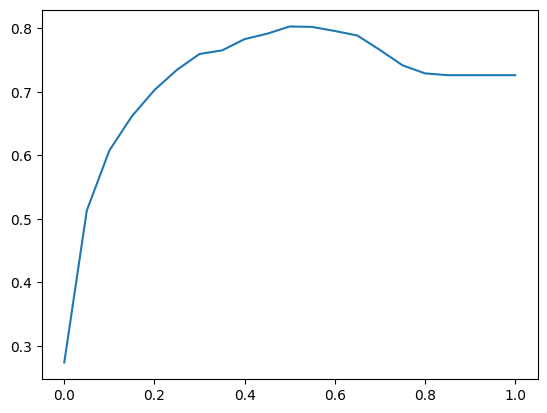

In [18]:
# Create a plot that shows how accuracy changes depending on the threshold
plt.plot(thresholds, scores)

It turns out that the 0.5 threshold is indeed the best choice for this specific problem. 

In [19]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.735
0.30 0.759
0.35 0.765
0.40 0.783
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


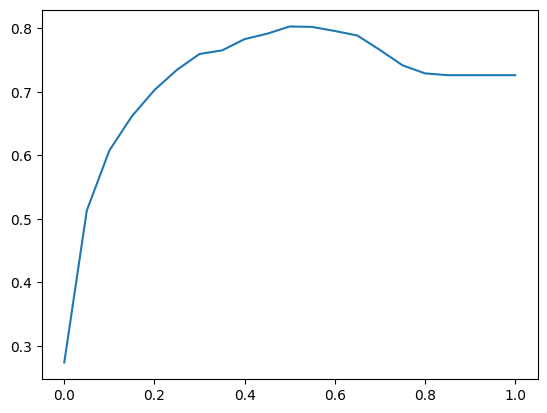

In [20]:
plt.plot(thresholds, scores)

In [21]:
from collections import Counter

In [22]:
# Count # of false values in dummy model predictions
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

To understand whether 80% is actually a good accuracy score, let's relate it to a simple baseline that's easy to understand. One such baseline could be a dummy model that always predicts the same value. 

In our churn prediction project, the dataset is imbalanced such that we don't have many churned customers. As such, the dummy model can always predict the majority class (no churn). In short, this model will always output False, regardless of the features. This kind of model is not super useful but can be used as a baseline when comparing the model with the other models. 

Our model: 80%

Dummy model: 73%

Our model is 7% more accurate than the dummy model. 


In [23]:
len(y_val)

1409

In [24]:
# Count # of false & true values in validation set
Counter(y_val)

Counter({np.int64(0): 1023, np.int64(1): 386})

In [25]:
y_val.mean()

np.float64(0.2739531582682754)

27% of the validation dataset are made up of customers that are churning.

In [26]:
1 - y_val.mean()

np.float64(0.7260468417317246)

About 73% of the validation dataset are made up of customers not churning. 

According to accuracy, our model is only slightly better than a dummy model that treats all the customers as non-churning and doesn't attempt to keep any of them. 

We also see that there is class imbalance (more instances of one class than another) in the dataset, where about 73% of customers did not churn, and only 27% did churn. In such cases, we need a different way of measuring the quality of our models because the accuracy metric can be misleading when we have class imbalance. 

## 4.3 Confusion table
Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. 
* Different types of errors and correct decisions
* Arranging them in a table

Considering this information, it is possible to evaluate the quality of the model by different strategies. 

When it comes to the predictions of a Logistic Regression model, each falls into one of four different categories:
- Customers for whom the model predicts "churn". This is known as the **Positive class**
    - The customers who actually churned - **True Positive (TP)**
        - $g(x_i) \geq t$, and
        - $y = 1$
    - The customers who actually didn't churn - **False Positive (FP)**
        - $g(x_i) \geq t$, and
        - $y = 0$
- Customers for whom the model predicts "no churn". This is known as the **Negative class**
    - The customer who actually didn't churn - **True Negative (TN)**
        - $g(x_i) \lt t$, and
        - $y = 0$
    - The customers who actually churned - **False Negative (FN)**
        - $g(x_i) \lt t$, and
        - $y = 1$

**Confusion Table** is a way to summarize the above results in a tabular format, concisely representing every possible outcome for our model's predictions. 

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

We can calculate **accuracy** by taking the sum of all the correct predictions (TN and TP) divided by the total number of observations in all four cells of the table:

$$accuracy = \frac {(TN + TP)}{(TN + TP + FN + FP)}$$

Apart from **accuracy**, we can calculate other metrics based on the values from the confusion table. The most useful ones are **precision** and **recall**.

In [27]:
# Implement confusion table in numpy

# Split the target variable y in validation into churn and no churn
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [28]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [29]:
actual_negative

array([ True,  True,  True, ...,  True, False, False])

In [30]:
# Split the predictions on validation set into churn and no churn
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [31]:
predict_positive

array([False, False, False, ..., False,  True,  True])

In [32]:
predict_negative

array([ True,  True,  True, ...,  True, False, False])

In [33]:
# Using binary operator '&' in numpy, return True only if both are true, else return False
predict_positive & actual_positive

array([False, False, False, ..., False,  True,  True])

In [34]:
# Combine prediction and actual into one and count how many of them
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [35]:
tp, tn, fp, fn

(np.int64(212), np.int64(919), np.int64(104), np.int64(174))

In [36]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[919, 104],
       [174, 212]])

Now we know what kind of errors the model makes. We have more false negatives than false positives. 

Two different types of errors, with false negatives being more difficult to catch. Our plan is to send promotional emails with discount to churning customers to retain the customer. The company lose profits if we send promotional emails to non-churning customers or if we failed to send promotional emails to churning customers. The latter has a bigger impact on the business than the former. 

In [37]:
# Instead of absolute numbers, we can have percents
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

This is how we get our 80% accuracy: 65% (TN) + 15% (TP)

## 4.4 Precision and Recall

Precision and recall are metrics for evaluating binary classification models. 

**Precision** tells us the fraction of positive predictions that are correct. It takes into account only the **positive class** (TP and FP - second column of the confusion matrix), as stated in the following formula:
$$P = \frac {TP}{TP + FP}$$

**Recall** measures the fraction of correctly identified positive instances. It considers parts of the **positive and negative classes** (TP and FN - second row of confusion table). The formula of this metric is presented below:
$$R = \frac {TP}{TP + FN}$$

In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the **class imbalance**. 

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

**MNEMONICS:**
- Precision: From the `pre`dicted positives, how many we predicted right. See how the word `pre`cision is similar to the word `pre`diction?
- Recall: From the `real` positives, how many we predicted right. See how the word `re`c`al`l is similar to the word `real`?


In [38]:
acc = (tp + tn) / (tp + tn + fp + fn)
acc

np.float64(0.8026969481902059)

In [39]:
p = tp / (tp + fp)
p

np.float64(0.6708860759493671)

In [40]:
1 - p

np.float64(0.3291139240506329)

Precision helps us understand how many customers received a promotional email by mistake. The better the precision, the fewer false positives we have. 

Approximately 33% are mistakes: customers who are not supposed to get this promotional email but they get it anyway. 

In [41]:
r = tp / (tp + fn)
r

np.float64(0.5492227979274611)

In [42]:
1 - r

np.float64(0.4507772020725389)

Recall helps us understand how many of the churning customers we failed to identify. The better the recall, the fewer false negatives we have. 

We failed to identify 46% of customers who are churning.

When we look at the 80% accuracy, it looks like it's a pretty high number and feels like this model must be very accurate. However, when we look at precision and recall, we see that our model is not that good. 

For the purpose of identifying churning customers, accuracy is not the best metric because we failed to identify 45% of customers who are churning and we actually send a promotional email to 33% of customers who were not going to churn but they probably will take advantage of our discount. So now, we see that our model is not as good as we thought it would be when looking at the accuracy metric alone. 

Accuracy can be misleading, especially in cases when we have class imbalance. Hence, it's useful to look at metrics like precision and recall. 

## 4.5 ROC Curves

**ROC** stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors in separating two signals (whether an airplane was there or not). Nowadays, it's used for a similar purpose: to show how well a model can separate two classes (positive and negative). This measure considers **False Positive Rate** (FPR) and **True Positive Rate** (TPR), which are derived from the values of the confusion matrix.

**FPR** is the fraction of false positives (FP) among all negative examples (FP and TN - the first row of confusion matrix), and we want to `minimize` it. The formula of FPR is the following:
$$FPR = \large \frac{FP} {FP + TN}$$

On the other hand, **TPR** or **Recall** is the fraction of true positives (TP) among all positive examples (FN and TP - the second row of confusion matrix), and we want to `maximize` this metric. The formula of this measure is presented below:
$$TPR = \large \frac{TP} {TP + FN}$$

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan="2"><b>Predictions</b></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Actual</b></td>
            <td><b>Negative</b></td>
            <td><b>Positive</b></td>
        </tr>
        <tr>
            <td><b>Negative</b></td>
            <td><b>TN</b></td>
            <td><b>FP</b></td>
        </tr>
        <tr>
            <td><b>Positive</b></td>
            <td><b>FN</b></td>
            <td><b>TP</b></td>
        </tr>
    </tbody>
</table>

ROC curves consider Recall and FPR under all the possible thresholds. If the threshold is 0 or 1, the FPR and Recall scores are the opposite of the threshold (1 and 0 respectively), but they have different meanings, as we explained before.

We need to compare the ROC curves against a point of reference to evaluate its performance, so the corresponding curves of random and ideal models are required. It is possible to plot the ROC curves with FPR and Recall scores vs. thresholds, or FPR vs. Recall. 

**Classes and Methods:**
- `np.repeat([x, y], [z, w])` - returns a numpy array with a z number of x values first, and then a w number of y values.
- `roc_curve(x, y)` - `sklearn.metrics` function for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset. 

### TPR and FRP

In [43]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [44]:
# TPR is the same as Recall
r

np.float64(0.5492227979274611)

In [45]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10166177908113393)

We want FPR to be as small as possible. 

For all the negative examples, 10% are predicted incorrectly. 

Binary classification models, such as logistic regression, typically output a probability score between zero and one. To make actual predictions, we binarize the output by setting some threshold to get only True and False values. 

Now, instead of evaluating the model at one particular threshold, we can do it for a range of them. For that, we first iterate over different threshold values and compute the values of the confusion table for each.


In [46]:
# Create an array to store thresholds from 0.0 to 1.0 with step 0.01
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [47]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    # Get the confusion table
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [48]:
# End up with 101 different confusion matrices
scores[:5]

[(np.float64(0.0), np.int64(386), np.int64(1023), np.int64(0), np.int64(0)),
 (np.float64(0.01), np.int64(385), np.int64(895), np.int64(1), np.int64(128)),
 (np.float64(0.02), np.int64(383), np.int64(804), np.int64(3), np.int64(219)),
 (np.float64(0.03), np.int64(382), np.int64(749), np.int64(4), np.int64(274)),
 (np.float64(0.04), np.int64(382), np.int64(709), np.int64(4), np.int64(314))]

In [49]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [50]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,245,94,778,0.756477,0.239492
40,0.4,255,175,131,848,0.660622,0.171065
50,0.5,212,104,174,919,0.549223,0.101662
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


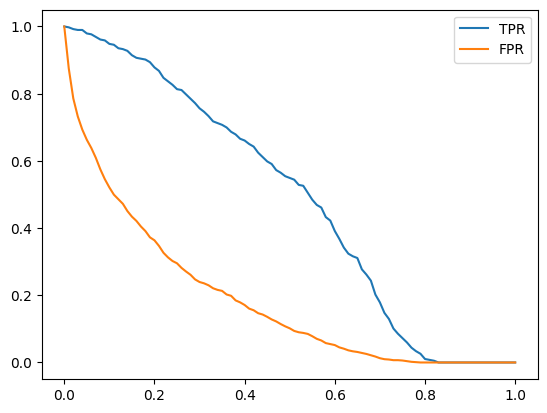

In [51]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

Both TPR and FPR start at 100% because at the threshold of 0.0, we predict "churn" for everyone:
- FPR is 100% because we have only false positives in the prediction. There are no true negatives: nobody is predicted as non-churning.
- TPR is 100% because we have only true positives and no false negatives.

As the threshold grows, both metrics decline but at different rates. Ideally, FPR should go down very quickly. A small FPR indicates that the model makes very few mistakes predicting negative examples (false positives). On the other hand, TPR should go down slowly, ideally staying near 100% all the time. A high TPR indicates that the model predicts true positives well. 

To better understand the meaning of TPR and FPR, let's compare it with two baseline models: a random model and an ideal model. 

### Random model

A random model outputs a random score between 0 and 1, regardless of the input. 

In [52]:
np.random.seed(1)
# Generates an array with random numbers between 0 and 1
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02])

In [53]:
# Pretends y_rand contains the predictions of our model
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

The accuracy for this model should be quite low. As we can see, it's 50%.

Let's calculate FPR and TPR for our random model. 

In [54]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [55]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


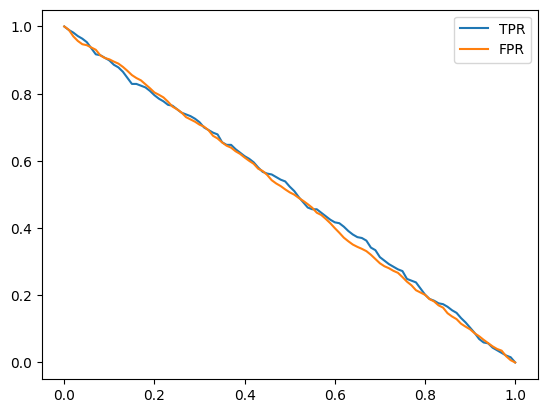

In [56]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

We can see that both TPR and FPR curves go from 100% to 0%, almost following the straight line. 

At the threshold of 0.0, we treat all customers as churning. Both TPR and FPR are 100%:
- FPR is 100% because we have only false positives: all non-churning customers are identified as churning.
- TPR is 100% because we have only true positives: we can correctly classify all churning customers as churning.

As we increase the threshold, both TPR and FPR decrease. At the threshold of 0.4, the model predicts a customer with a probability of 40% as "non-churn", and predicts a customer with a probability of 60% as "churn". Both TPR and FPR are 60%:
- FPR is 60% because we incorrectly classify 60% of non-churning customers as churning.
- TPR is 60% because we correctly classify 60% of churning customers as churning.

Finally, at 1.0, both TPR and FPR are 0%. At this threshold, we predict everybody as non-churning:
- FPR is 0% because we have no false positives: we can correctly classify all non-churning customers as non-churning.
- TPR is 0% because we have no true positives: all churning customers are identified as non-churning.

### Ideal model
The ideal model always makes correct decisions. We'll take it a step further and consider the ideal ranking model. This model outputs scores in such a way that churning customers always have higher scores than non-churning ones. In other words, the predicted probability for all churned ones should be higher than the predicted probability for non-churned ones. 

So, if we apply the model to all the customers in our validation set and then sort them by the predicted probability, we first will have all the non-churning customers, followed by the churning ones. For example if the threshold is 0.72, where 72% are non churning customers and 28% are churning customers, a threshold of 0.7x will give us a model with 100% accuracy because it will classify every non-churning customer as non-churning and every churning customer as churning. The customers are ordered in such a way that there is a clear-cut between non-churning customers and churning customers. 

Although attaining such a model in real life is unlikely, it's still useful for comparing our TPR and FPR to the TPR and FPR of the ideal model. 

In [57]:
# Calculates the number of negative and positive examples in dataset
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [58]:
# Generates an array that first repeats 0s num_neg number of times, 
# followed by 1s repeated num_pos number of times
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [59]:
# Generates the predictions of the model: numbers that grow from 0 in 
# the first cell to 1 in the last
y_ideal_pred = np.linspace(0, 1, len(y_val))
y_ideal_pred

array([0.00000000e+00, 7.10227273e-04, 1.42045455e-03, ...,
       9.98579545e-01, 9.99289773e-01, 1.00000000e+00])

In [60]:
((y_ideal_pred >= 0.72) == y_ideal).mean()

np.float64(0.99361249112846)

In [61]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [62]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [63]:
# Computes the TPR and FPR curves for the classifier
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


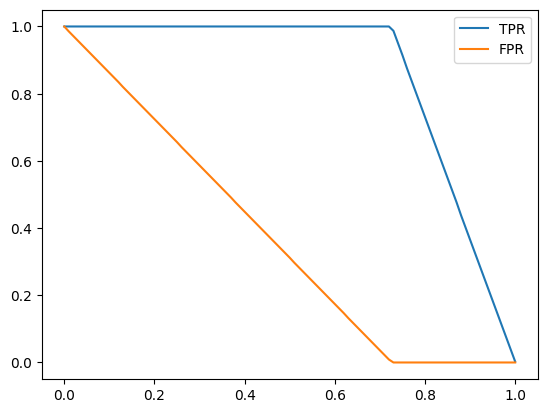

In [64]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

From the plot, we can see that
- Both TPR and FPR start at 100% and end at 0%.
- For thresholds lower than 0.726, we always correctly classify all churning customers as churning; that's why TPR stays at 100%. On the other hand, we incorrectly classify some non-churning ones as churning--those are our false positives. As we increase the threshold, fewer and fewer non-churning customers are classified as churning, so FPR goes down.
- The threshold of 0.726 is the ideal situation: all churning customers are classified as churning, and all non-churning are classified as non-churning; that's why TPR is 100% and FPR is 0%.
- Between 0.74 and 1.0, we always correctly classify all non-churning customers, so FPR stays at 0%. However, as we increase the threshold, we start incorrectly classifying more and more churning customers as non-churning, so TPR goes down. 

### Putting everything together

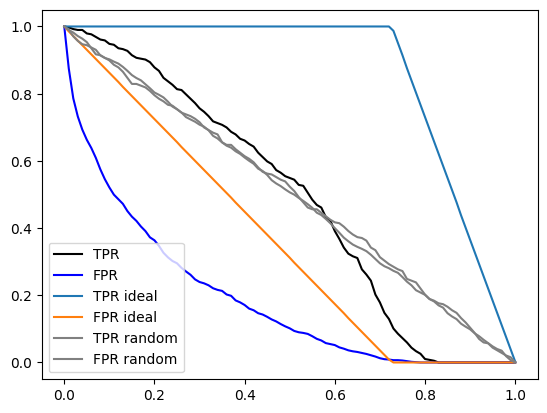

In [65]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

Plotting it against the threshold is not always intuitive because for example, for our model, the best threshold as we know is 0.5, at least in terms of accuracy. But for the ideal model, the best threshold is 0.726. 

So the models have different thresholds, and what we can do is to plot FPR against TPR, ignoring the thresholds in our plot. 

In brief, we're creating an ROC curve by plotting FPR and TPR against each other instead of against different threshold values. For comparison, we also add the ideal and random models to the plot. 

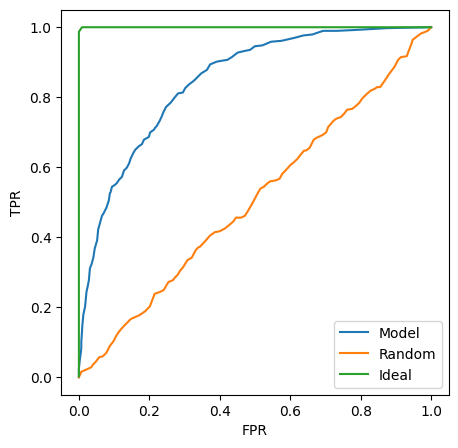

In [66]:
# Usually the plot size for ROC curves are square and not rectangular
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

We can see that the ROC curve of the random classifier is an approximately straight line from bottom left to top right. For the ideal model, however, the curve first goes up until it reaches 100% TPR, and from there, it goes right until it reaches 100% FPR. 

Our models should always be somewhere between these two curves. We want our model to be as close to the ideal curve as possible and as far as possible from the random curve. 

The ROC curve of a random model serves as a good visual baseline--when we add it to the plot, it helps us to judge how far our model is from this baseline--so it's a good idea to always include this line in the plot. 

However, we don't really need to generate a random model each time we want to have an ROC curve: we know what it looks like, so we can simply include a straight line from (0, 0) to (1, 1) in the plot. 

As for the ideal model, we know that it always goes up to (0, 1) and then goes right to (1, 1). The top-left corner is called the "ideal spot": it's the point when the ideal model gets 100% TPR and 0% FPR. We want our models to get as close to the ideal spot as possible. 

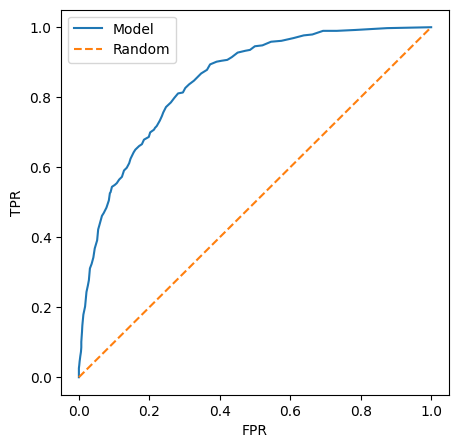

In [67]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Although computing all the FPR and TPR values across many thresholds is a good exercise, we don't need to do it ourselves every time we want to plot an ROC curve. We simply can use the `roc_curve` function from the `metrics` package of Scikit-learn. 

In [68]:
from sklearn.metrics import roc_curve

In [69]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

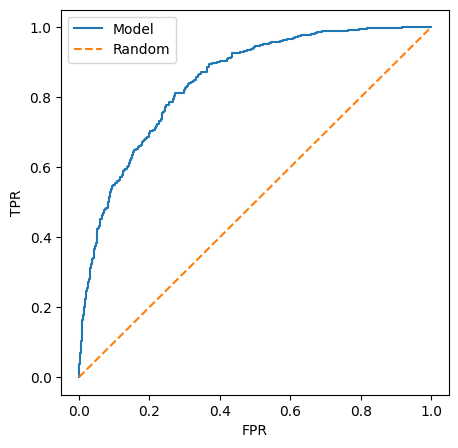

In [70]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Using a ROC curve, we can see how the model behaves at different thresholds.

When we start at high threshold values, all models are equal: any model at high threshold values degrades to the constant "model" that predicts False all the time. As we decrease the threshold, we start predicting some of the customers as churning. The better the model, the more customers are correctly classified as churning, resulting in a better TPR. Likewise, good models have a smaller FPR because they have fewer false positives. 

Thus, the ROC curve of a good model first goes up as high as it can and only then starts turning right. Poor models, on the other hand, from the start have higher FPRs and lower TPRs, so their curves tend to go to the right earlier. 

If for some reasons our model is getting somewhere below the random model baseline, we're making a mistake here. Our models should not go below the random model baseline. If we see that our model goes below random baseline, it means that we need to flip positive and negative predictions (something is wrong and we've a mistake somewhere). 


## 4.6 ROC AUC
ROC curves are quite useful on their own, but we also have another metric that's based on it: AUC, or the area under the ROC curve.

When evaluating our models using the ROC curve, we want them to be as close to the ideal spot and as far from the random baseline as possible. 

We can quantify this "closeness" by measuring the area under the ROC curve. We can use this metric--abbreviated as AU ROC, or often simply AUC--as a metric for evaluating the performance of a binary classification model.

The ideal model forms a 1x1 square, so the area under its ROC curve is 1, or 100%. The random model takes only half of that, so its AUC is 0.5, or 50%. The AUCs of our models will be somewhere between the random baseline of 50% and the ideal curve of 100%. 
* Area under the ROC curve - useful metric
* Interpretation of AUC

An AUC of 0.9 is indicative of a reasonably good model; 0.8 is okay, 0.7 is not very performant, and 0.6 indicates quite poor performance. 

**Classes and methods:**
- `auc(x, y)` - `sklearn.metrics` function for calculating area under the curve of the x and y datasets. For ROC curves, x would be false positive rate (FPR), and y would be true positive rate (TPR).
- `roc_auc_score(x, y)` - `sklearn.metrics` function for calculating area under the ROC curves of the x false positive rate (FPR) and y true positive rate (TPR) datasets.
- `randint(x, y)` - `random` package function for returning a random integer in range [x, y], including both end points.
- `randint(x, y, size=z)` - `np.random` function for generating random integers from the "discrete uniform" distribution; from `x` (inclusive) to `y` (exclusive) of size `z`.


In [71]:
from sklearn.metrics import auc

In [72]:
auc(fpr, tpr)

np.float64(0.8464158550235769)

In [73]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.8461727419608083)

In [74]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9999430203759136)

In [75]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

np.float64(0.8464158550235769)

If all we need is the AUC, we don't need to compute the ROC curve first. We can use the `roc_auc_score` function from Scikit-learn, which takes care of everything and simply returns the AUC of our model. 

In [76]:
from sklearn.metrics import roc_auc_score

In [77]:
roc_auc_score(y_val, y_pred)

np.float64(0.8464158550235769)

>The value from `roc_auc_score` may be slightly different from AUC computed from the dataframes where we calculated TPR and FPR ourselves: Scikit-learn internally uses a more precise method for creating ROC curves. 

ROC curves and AUC scores tell us how well the model separates positive and negative examples. What is more, AUC has a nice probabilistic interpretation: it tells us what the probability is that a randomly selected positive example will have a score higher than a randomly selected negative example. 

Suppose we randomly pick a customer that we know churned and a customer who didn't and then apply the model to these customers and see what the score is for each. We want the model to score the churning customer higher than the non-churning one. AUC tells us the probability of that happening: it's the probability that the score of a randomly selected churning customer is higher than the score of a randomly selected non-churning one. 

$$P(churn(0.50) > non\_churn(0.60)) = AUC$$

We can verify this by performing this experiment 10,000 times and then count how many times the score of the positive example was higher than the score of the negative one, the percentage of cases when it's true should roughly correspond to the AUC.

In [78]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [79]:
neg

array([0.00665474, 0.20473376, 0.21748429, ..., 0.08335068, 0.29115403,
       0.15187937])

In [80]:
pos

array([0.56440731, 0.59322217, 0.46651607, 0.73691994, 0.08234238,
       0.69571614, 0.24757298, 0.68700347, 0.21808786, 0.66251937,
       0.438262  , 0.35267698, 0.17147012, 0.58983224, 0.74968058,
       0.16110654, 0.43367213, 0.28541241, 0.0753382 , 0.22520356,
       0.65467419, 0.41910712, 0.66927831, 0.56793839, 0.5398981 ,
       0.44160416, 0.48359808, 0.33328015, 0.58514734, 0.34708741,
       0.60941313, 0.72984335, 0.728683  , 0.58852443, 0.6806319 ,
       0.76261285, 0.11014946, 0.20159257, 0.51345549, 0.56492083,
       0.46841832, 0.48020053, 0.74909354, 0.38920775, 0.68803272,
       0.42444916, 0.74487643, 0.3158917 , 0.53675329, 0.57029486,
       0.11349388, 0.54286193, 0.78047486, 0.4509808 , 0.68770984,
       0.75960796, 0.01456997, 0.36935001, 0.77633674, 0.57435285,
       0.68003765, 0.26536326, 0.36820086, 0.70068365, 0.21802211,
       0.69603622, 0.63371711, 0.3114963 , 0.67761755, 0.31496763,
       0.51875368, 0.27813791, 0.42900326, 0.41957147, 0.51694

In [81]:
import random

In [82]:
random.randint(0, len(pos) - 1)

207

In [83]:
pos_ind = random.randint(0, len(pos) - 1)
neg_ind = random.randint(0, len(neg) - 1)

pos[pos_ind] > neg[neg_ind]

np.False_

In [84]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84488

The result is pretty close to the AUC value of our classifier. 


With numpy, we can just generate 50000 random positive indexes and 50000 random negatives indexes.

In [85]:
# Implement the same thing but with numpy
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.84904)

This interpretation of AUC gives us additional insight into the quality of our models. The ideal model orders all the customers such that we first have non-churning customers and then churning customers. With this order, the AUC is always 1.0: the score of a randomly chosen churning customer is always higher than the score of a non-churning customer. On the other hand, the random model just shuffles the customers, so the score of a churning customer has only a 50% chance of being higher than the score of a non-churning one. 

AUC thus not only gives us a way of evaluating the models at all possible thresholds but also describes how well the model separates two classes: in our case, churning and non-churning. If the separation is good, then we can order the customers such that most of the churning users come first. Such a model will have a good AUC score. 

This makes AUC the default classification metric in most situations, and it's often the metric we use when finding the best parameter set for our models (parameter tuning).

## 4.7 Cross-Validation
It's possible to use all the available data to assess the quality of models and get more reliable validation results. We can simply perform validation multiple times.

**Cross-validations** refers to evaluating the same model on different subsets of a dataset, getting the average prediction, and spread within predictions. This method is applied in the **parameter tuning** step, which is the process of selecting the best parameter. 
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In this algorithm, the full training dataset is divided into **k partitions**, we train the model in k-1 partitions of this dataset and evaluate it on the remaining subset. Then, we end up evaluating the model in all the k folds, and we calculate the average evaluation metric for all the folds.

In general, if the dataset is large, we should use the hold-out validation dataset strategy. On the other hand, if the dataset is small or we want to know the standard deviation of the model across different folds, we can use the cross-validation approach. Also, for bigger dataset, the number of splits could be two or three. And for smaller dataset, maybe you want to do more splits like 10 or something.

The standard deviation will show us how stable the model is, or how far it may deviate from the average. A good model should be quite stable across different folds. The smaller the standard deviation is, the more stable the model is. 

**Libraries, classes and methods:**
- `Kfold(k, s, x)` - `sklearn.model_selection` class for calculating the cross-validation with k folds, s boolean attribute for shuffle decision, and an x random state.
- `Kfold.split(x)` - `sklearn.Kfold` method for splitting the x dataset with the attributes established in the Kfold's object construction.
- `for i in tqdm()` - library for showing the progress of each i-iteration in a for loop.

In [86]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)
    
    return dv, model

In [87]:
dv, model = train(df_train, y_train, C=0.001)

In [88]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [89]:
y_pred = predict(df_val, dv, model)

In [90]:
from sklearn.model_selection import KFold

In [91]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
kfold

KFold(n_splits=10, random_state=1, shuffle=True)

In [92]:
kfold.split(df_full_train)

<generator object _BaseKFold.split at 0x0000027A88389C60>

In [93]:
# Returns two arrays: First one is indexes for train part and then 
# second one is indexes for validation part
next(kfold.split(df_full_train))

(array([   0,    1,    2, ..., 5631, 5632, 5633]),
 array([   4,   21,   28,   33,   44,   58,   67,   72,   79,   81,   82,
          98,  101,  116,  119,  125,  126,  136,  141,  147,  161,  169,
         179,  192,  196,  200,  206,  214,  222,  231,  250,  255,  259,
         276,  280,  285,  301,  308,  313,  314,  325,  343,  354,  359,
         383,  386,  407,  420,  428,  433,  440,  447,  457,  473,  486,
         496,  501,  503,  507,  545,  554,  557,  566,  574,  580,  582,
         592,  605,  608,  623,  634,  636,  645,  662,  667,  684,  687,
         689,  729,  745,  758,  763,  778,  783,  792,  795,  808,  839,
         840,  847,  850,  858,  867,  870,  871,  881,  899,  906,  927,
         929,  931,  940,  943,  976,  984,  987,  988, 1005, 1016, 1028,
        1034, 1038, 1050, 1056, 1074, 1079, 1117, 1122, 1123, 1131, 1134,
        1139, 1144, 1155, 1159, 1163, 1169, 1179, 1198, 1206, 1216, 1238,
        1247, 1256, 1272, 1297, 1298, 1310, 1344, 1356, 1370,

In [94]:
train_idx, val_idx = next(kfold.split(df_full_train))
len(train_idx), len(val_idx)

(5070, 564)

In [95]:
len(df_full_train)

5634

In [96]:
df_full_train.iloc[train_idx]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
1814,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
5946,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
3881,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
2389,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
611,4765-oxppd,female,0,yes,yes,9,yes,no,dsl,yes,...,yes,yes,no,no,month-to-month,no,mailed_check,65.00,663.05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2763,2250-ivbwa,male,0,yes,yes,64,yes,no,fiber_optic,yes,...,no,no,no,no,month-to-month,no,electronic_check,81.05,5135.35,0
5192,3507-gasnp,male,0,no,yes,60,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.95,1189.90,0
3980,8868-wozgu,male,0,no,no,28,yes,yes,fiber_optic,no,...,yes,no,yes,yes,month-to-month,yes,electronic_check,105.70,2979.50,1
235,1251-krreg,male,0,no,no,2,yes,yes,dsl,no,...,no,no,no,no,month-to-month,yes,mailed_check,54.40,114.10,1


In [97]:
df_full_train.iloc[val_idx]

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
3676,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0
6672,2346-czyil,male,0,no,no,27,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,credit_card_(automatic),20.35,531.60,0
6203,1090-pykci,female,0,yes,yes,69,yes,yes,fiber_optic,yes,...,yes,yes,yes,no,one_year,yes,credit_card_(automatic),105.10,7234.80,0
1374,8999-ypybv,male,0,yes,yes,45,yes,no,dsl,yes,...,yes,yes,yes,yes,two_year,yes,mailed_check,84.35,3858.05,0
4902,5092-stpkp,female,0,no,no,24,yes,no,dsl,yes,...,no,yes,no,no,month-to-month,no,credit_card_(automatic),56.35,1381.20,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6121,7337-cinud,female,0,yes,yes,8,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,bank_transfer_(automatic),19.50,159.35,0
562,3701-sfmuh,male,0,yes,yes,7,yes,no,dsl,yes,...,no,no,yes,yes,month-to-month,no,credit_card_(automatic),69.70,516.15,0
2962,3237-ajgeh,female,0,yes,yes,3,no,no_phone_service,dsl,no,...,no,yes,no,no,month-to-month,yes,mailed_check,31.00,95.05,1
5056,3262-eidhv,female,0,yes,yes,72,yes,yes,dsl,yes,...,yes,yes,yes,yes,two_year,no,credit_card_(automatic),84.70,5893.90,0


In [98]:
!pip install tqdm

In [99]:
from tqdm.auto import tqdm

In [100]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


When the C parameter is small, the model is more regularized. The weights of this model are more restricted, so in general, they are smaller. Small weights in the model give us additional assurance that the model will behave well when we use it on real data. 

In [101]:
scores

[np.float64(0.8439410947398167),
 np.float64(0.8447742848629322),
 np.float64(0.833646397752358),
 np.float64(0.8347089435313678),
 np.float64(0.852087320761821)]

In [102]:
np.mean(scores), np.std(scores)

(np.float64(0.8418316083296592), np.float64(0.0068705013151719166))

Train the model on the entire train and validation datasets and apply it to the test dataset to verify it indeed works well.

In [103]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8583598751990639)

The performance of the model (AUC) on the held-out test set is 0.858. 

That's a little higher than what we had on the validation set, but that's not an issue; it could happen just by chance. What's important is that the score is not significantly different from the validation score. 1% or 2% difference between performance on the validation set and the test set is ok. 

## 4.8 Summary
General definitions:
* Metric - a single number that describes the performance of a model
* Accuracy - fraction of correct answers; sometimes misleading 
* Precision and recall are less misleading when we have class inbalance
* ROC Curve - a way to evaluate the performance at all thresholds; okay to use with imbalance
* K-Fold CV - more reliable estimate for performance (mean + std)

In brief, this session was about different metrics to evaluate a binary classifier. These measures included accuracy, confusion table, precision, recall, ROC curves (TPR, FPR, random model, and ideal model), and AUROC. Also, we talked about a different way to estimate the performance of the model and perform parameter tuning with cross-validation.

## 4.9 Explore more

* Check the precision and recall of the dummy classifier that always predict "FALSE"
* F1 score = 2 * P * R / (P + R)
* Evaluate precision and recall at different thresholds, plot P vs R - this way you'll get the precision/recall curve (similar to ROC curve)
* Area under the PR curve is also a useful metric

Other projects:

* Calculate the metrics for datasets from the previous week

#### Further Reading
- When plotting precision and recall for different threshold values, we can see that a conflict exists between precision and recall: when one goes up, the other goes down, and the other way around. This is called the "precision-recall trade-off": we cannot select a threshold that makes both precision and recall good. However, we do have strategies for selecting the threshold, even though precision and recall are conflicting. One of them is plotting precision and recall curves and seeing where they intersect, and using this threshold for binarizing the predictions. 
- Another idea for working around the precision-recall trade-off is the F1 score--a score that combines both precision and recall into one value. Then, to select the best threshold, we can simply choose the one that maximizes the F1 score. The formula for computing the F1 score is F1 = 2 * P * R / (P + R), where P is precision and R is recall. 
- We've seen that precision and recall are better metrics for evaluating classification models than accuracy because they don't rely on false positives, the amount of which could be high in imbalanced datasets. Yet, we saw later that AUC does actually use false positives in FPR. For very highly imbalanced cases (say, 1,000 negatives to 1 positive), AUC may become problematic as well. Another metric works better in such cases: area under the precision-recall curve, or AU PR. The precision-recall curve is similar to ROC, but instead of plotting FPR versus TPR, we plot recall on the x-axis and precision on the y-axis. Like for the ROC curve, we can also calculate the area under the PR curve and use it as a metric for evaluating different models. 
- We covered K-fold cross-validation, and we used it to understand what the distribution of AUC scores could like on a test dataset. When K = 10, we get 10 observations, which under some circumstances might not be enough. However, the idea can be extended to repeated K-fold cross-validation steps. The process is simple: we repeat the K-fold cross-validation process multiple times, each time shuffling the dataset differently by selecting a different random seed at each iteration. Implement repeated cross-validation and perform 10-fold cross-validation 10 times to see what the distribution of scores looks like. 